In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import shutil 
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

import albumentations as A 

import torch, torchvision
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torchvision.transforms import functional as F

import os, time, copy

In [2]:
data_root = 'D:/kaggle_data/sobes/journey-springfield/'
print(os.listdir(data_root))

['characters_illustration.png', 'sample_submission.csv', 'test', 'testset', 'train', 'trainset', 'train_augmentation', 'val']


In [3]:
train_dir = 'train'
val_dir = 'val'
train_dataset = 'trainset/simpsons_dataset'

class_names = os.listdir(os.path.join(data_root, train_dataset)) #create list with class names

In [4]:
def visualize(image):
    image = cv2.imread(image)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [5]:
# find characters who have few images
characters_img = {}
for class_name in class_names:
    characters_img[class_name] = len(os.listdir(os.path.join(data_root, train_dataset, class_name)))

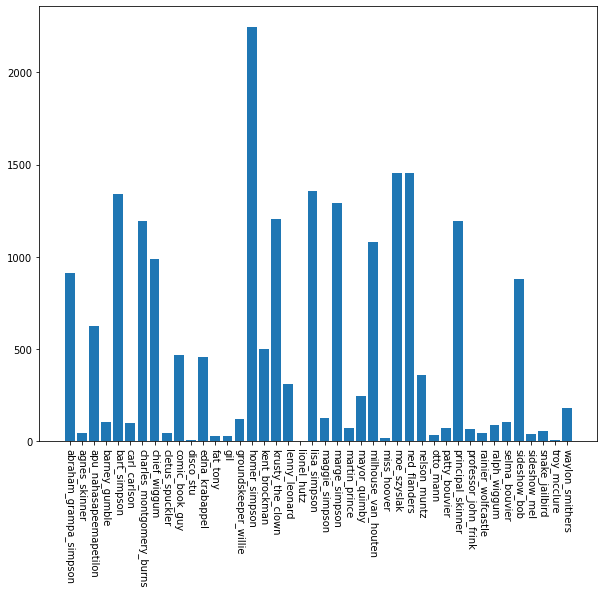

In [6]:
plt.subplots(figsize=(10,8))
plt.bar(range(len(characters_img)), characters_img.values())
plt.xticks(range(len(characters_img)), characters_img.keys(), rotation=-90)
plt.show()

In [7]:
# we see that some characters has few images for model training
# let's find them
characters_augm = []
for i in characters_img:
    if characters_img[i] <= 400:
        characters_augm.append(i)
print('{} out of {} have few images in their class'.format(len(characters_augm), len(class_names)))        

25 out of 42 have few images in their class


In [8]:
# copy images that create augmentation folder
for class_name in class_names:
        os.makedirs(os.path.join(data_root, 'train_augmentation', class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, train_dataset, class_name)
    dest_dir = os.path.join(data_root, 'train_augmentation', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if file_name not in os.listdir(dest_dir):
            shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        #else:
        #    if i % 100 == 0:
        #            print('Files exist in folder'.format(file_name))

100%|██████████| 181/181 [00:00<00:00, 232.71it/s]


In [9]:
start_augm = False
for augm_class in characters_augm:
    augm_dir = os.path.join(data_root, 'train_augmentation', augm_class)
    transform = A.Compose([
    A.CLAHE(p=0.2),
    #A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.MotionBlur(p=0.2),
    A.Sharpen(p=0.5),
    A.RandomContrast(p=0.2),
    A.OpticalDistortion(p=0.5),
    #A.GridDistortion(p=0.5),
    ])
    augm_dir = os.path.join(data_root, 'train_augmentation', augm_class)
    if start_augm == True:
        for x in range(3):
            for i, file_name in enumerate(tqdm(os.listdir(augm_dir))):
                image = cv2.imread(os.path.join(augm_dir, file_name))
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                transformed = transform(image=image)
                cv2.imwrite(os.path.join(augm_dir, '{}_aug_{}.jpg'.format(file_name, x)), transformed['image'])

                r = np.random.choice(500)
                if i == r:
                    fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False)      
                    # Representation
                    sample = cv2.cvtColor(transformed['image'], cv2.COLOR_BGR2RGB)
                    axes[0, 0].imshow(sample)
    


c:\Users\kinkp\Envs\torch\lib\site-packages\albumentations\augmentations\transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [10]:
# create training and validation folders with images
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(data_root, dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train_augmentation', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(data_root, train_dir, class_name) 
        else:
            dest_dir = os.path.join(data_root, val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 1448/1448 [00:32<00:00, 44.80it/s]


In [28]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    train_dir: transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    val_dir: transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = data_root
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [train_dir, val_dir]}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in [train_dir, val_dir]}
dataset_sizes = {x: len(image_datasets[x]) for x in [train_dir, val_dir]}
class_names = image_datasets[train_dir].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

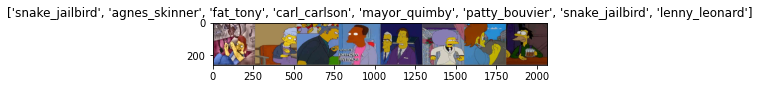

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[train_dir]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [32]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [33]:
model = models.vgg16_bn(pretrained=True)

In [34]:
#model

In [35]:

for param in model.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
#num_ftrs = model.fc.in_features
num_ftrs = model.classifier[6].in_features
#model.fc = torch.nn.Linear(in_features=num_ftrs, out_features=len(class_names))
model.classifier[6] = torch.nn.Linear(in_features=num_ftrs, out_features=len(class_names))

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [36]:
for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True

In [37]:
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [38]:
model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


100%|██████████| 3855/3855 [07:18<00:00,  8.79it/s]


train Loss: 1.4027 Acc: 0.6179


100%|██████████| 774/774 [01:13<00:00, 10.46it/s]


val Loss: 0.5474 Acc: 0.8494

Epoch 1/19
----------


100%|██████████| 3855/3855 [07:28<00:00,  8.60it/s]


train Loss: 0.6014 Acc: 0.8285


100%|██████████| 774/774 [01:12<00:00, 10.71it/s]


val Loss: 0.3034 Acc: 0.9176

Epoch 2/19
----------


100%|██████████| 3855/3855 [07:43<00:00,  8.31it/s]


train Loss: 0.3755 Acc: 0.8896


100%|██████████| 774/774 [01:11<00:00, 10.77it/s]


val Loss: 0.2607 Acc: 0.9297

Epoch 3/19
----------


100%|██████████| 3855/3855 [07:21<00:00,  8.72it/s]


train Loss: 0.2648 Acc: 0.9236


100%|██████████| 774/774 [01:13<00:00, 10.59it/s]


val Loss: 0.2385 Acc: 0.9355

Epoch 4/19
----------


100%|██████████| 3855/3855 [07:17<00:00,  8.80it/s]


train Loss: 0.2014 Acc: 0.9411


100%|██████████| 774/774 [01:15<00:00, 10.24it/s]


val Loss: 0.2018 Acc: 0.9441

Epoch 5/19
----------


100%|██████████| 3855/3855 [07:34<00:00,  8.48it/s]


train Loss: 0.1584 Acc: 0.9538


100%|██████████| 774/774 [01:11<00:00, 10.83it/s]


val Loss: 0.1930 Acc: 0.9455

Epoch 6/19
----------


100%|██████████| 3855/3855 [07:31<00:00,  8.53it/s]


train Loss: 0.1266 Acc: 0.9623


100%|██████████| 774/774 [01:11<00:00, 10.82it/s]


val Loss: 0.1737 Acc: 0.9543

Epoch 7/19
----------


100%|██████████| 3855/3855 [07:03<00:00,  9.11it/s]


train Loss: 0.0772 Acc: 0.9779


100%|██████████| 774/774 [01:10<00:00, 10.92it/s]


val Loss: 0.1608 Acc: 0.9568

Epoch 8/19
----------


100%|██████████| 3855/3855 [06:59<00:00,  9.20it/s]


train Loss: 0.0668 Acc: 0.9809


100%|██████████| 774/774 [01:10<00:00, 10.91it/s]


val Loss: 0.1601 Acc: 0.9588

Epoch 9/19
----------


100%|██████████| 3855/3855 [07:28<00:00,  8.60it/s]


train Loss: 0.0586 Acc: 0.9839


100%|██████████| 774/774 [01:12<00:00, 10.72it/s]


val Loss: 0.1591 Acc: 0.9591

Epoch 10/19
----------


100%|██████████| 3855/3855 [07:15<00:00,  8.84it/s]


train Loss: 0.0588 Acc: 0.9834


100%|██████████| 774/774 [01:12<00:00, 10.62it/s]


val Loss: 0.1602 Acc: 0.9601

Epoch 11/19
----------


100%|██████████| 3855/3855 [07:19<00:00,  8.77it/s]


train Loss: 0.0484 Acc: 0.9860


100%|██████████| 774/774 [01:13<00:00, 10.56it/s]


val Loss: 0.1591 Acc: 0.9599

Epoch 12/19
----------


100%|██████████| 3855/3855 [06:42<00:00,  9.58it/s]


train Loss: 0.0490 Acc: 0.9861


100%|██████████| 774/774 [00:56<00:00, 13.68it/s]


val Loss: 0.1663 Acc: 0.9557

Epoch 13/19
----------


100%|██████████| 3855/3855 [07:39<00:00,  8.38it/s] 


train Loss: 0.0475 Acc: 0.9858


100%|██████████| 774/774 [01:12<00:00, 10.61it/s]


val Loss: 0.1542 Acc: 0.9598

Epoch 14/19
----------


100%|██████████| 3855/3855 [07:26<00:00,  8.64it/s]


train Loss: 0.0465 Acc: 0.9859


100%|██████████| 774/774 [01:12<00:00, 10.64it/s]


val Loss: 0.1537 Acc: 0.9615

Epoch 15/19
----------


100%|██████████| 3855/3855 [07:30<00:00,  8.56it/s]


train Loss: 0.0453 Acc: 0.9870


100%|██████████| 774/774 [01:12<00:00, 10.60it/s]


val Loss: 0.1594 Acc: 0.9596

Epoch 16/19
----------


100%|██████████| 3855/3855 [07:26<00:00,  8.64it/s]


train Loss: 0.0455 Acc: 0.9867


100%|██████████| 774/774 [01:13<00:00, 10.57it/s]


val Loss: 0.1566 Acc: 0.9604

Epoch 17/19
----------


100%|██████████| 3855/3855 [07:41<00:00,  8.35it/s]


train Loss: 0.0423 Acc: 0.9878


100%|██████████| 774/774 [01:12<00:00, 10.67it/s]


val Loss: 0.1532 Acc: 0.9615

Epoch 18/19
----------


100%|██████████| 3855/3855 [08:13<00:00,  7.82it/s]


train Loss: 0.0419 Acc: 0.9878


100%|██████████| 774/774 [02:16<00:00,  5.65it/s]


val Loss: 0.1547 Acc: 0.9593

Epoch 19/19
----------


100%|██████████| 3855/3855 [08:35<00:00,  7.48it/s] 


train Loss: 0.0453 Acc: 0.9875


100%|██████████| 774/774 [01:13<00:00, 10.60it/s]

val Loss: 0.1530 Acc: 0.9619

Training complete in 174m 40s
Best val Acc: 0.961856


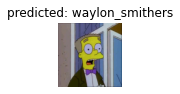

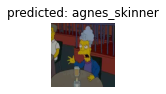

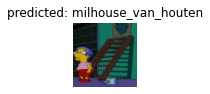

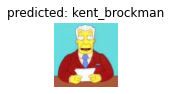

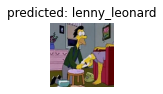

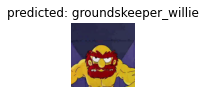

In [39]:
visualize_model(model)

plt.ioff()
plt.show()

In [44]:
test_dir = 'testset'
try:
    shutil.copytree(os.path.join(data_root, test_dir, 'testset'), os.path.join(data_root, 'test', 'unknown'))
except:
    print('Folder exist!')

Folder exist!


In [45]:
test_image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms[val_dir])
test_dataloaders = DataLoader(test_image_datasets, batch_size=4, shuffle=False, num_workers=4)
test_dataset_sizes = len(test_image_datasets)
#class_names = test_image_datasets.classes

In [46]:
submission = pd.DataFrame(columns=['Id', 'Expected'])

In [47]:
def predict_model(model):
    was_training = model.training
    model.eval()
    pred_classes = []

    with torch.no_grad():
        for i, (inputs, _) in tqdm(enumerate(test_dataloaders)):
            inputs = inputs.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                #submission = pd.concat([submission, pd.DataFrame([[inputs.cpu().data[j], 
                #                                                  class_names[preds[j]]]], columns=['Id', 'Expected'])])
                #print(test_dataloaders.dataset.imgs[j][0].split('\\')[-1])
                pred_classes.append(class_names[preds[j]])
                
                

                
        model.train(mode=was_training)
    
    return pred_classes

In [48]:
pred_classes = predict_model(model)

248it [00:13, 18.54it/s]


In [49]:
img_names = [test_dataloaders.dataset.imgs[i][0].split('\\')[-1] for i in range(len(pred_classes))]

In [50]:
submission['Id'], submission['Expected'] = img_names, pred_classes

In [51]:
submission.sample(5)

,Id,Expected
115,img201.jpg,homer_simpson
449,img502.jpg,ned_flanders
189,img269.jpg,chief_wiggum
292,img361.jpg,lenny_leonard
947,img951.jpg,abraham_grampa_simpson


In [52]:
submission.to_csv('./simpson_classification.csv', index=False)